In [1]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import numpy as np
import matplotlib.pyplot as plt

from src.ulam.generate import generate_ulam_spiral, generate_prime_mask

%matplotlib inline


In [2]:
SIZE = 101  # must be odd

spiral = generate_ulam_spiral(SIZE)
prime_mask = generate_prime_mask(spiral)

spiral[:10, :10], prime_mask[:10, :10]


(array([[10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109,
         10110],
        [10100,  9703,  9704,  9705,  9706,  9707,  9708,  9709,  9710,
          9711],
        [10099,  9702,  9313,  9314,  9315,  9316,  9317,  9318,  9319,
          9320],
        [10098,  9701,  9312,  8931,  8932,  8933,  8934,  8935,  8936,
          8937],
        [10097,  9700,  9311,  8930,  8557,  8558,  8559,  8560,  8561,
          8562],
        [10096,  9699,  9310,  8929,  8556,  8191,  8192,  8193,  8194,
          8195],
        [10095,  9698,  9309,  8928,  8555,  8190,  7833,  7834,  7835,
          7836],
        [10094,  9697,  9308,  8927,  8554,  8189,  7832,  7483,  7484,
          7485],
        [10093,  9696,  9307,  8926,  8553,  8188,  7831,  7482,  7141,
          7142],
        [10092,  9695,  9306,  8925,  8552,  8187,  7830,  7481,  7140,
          6807]]),
 array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0

(np.float64(-0.5), np.float64(100.5), np.float64(100.5), np.float64(-0.5))

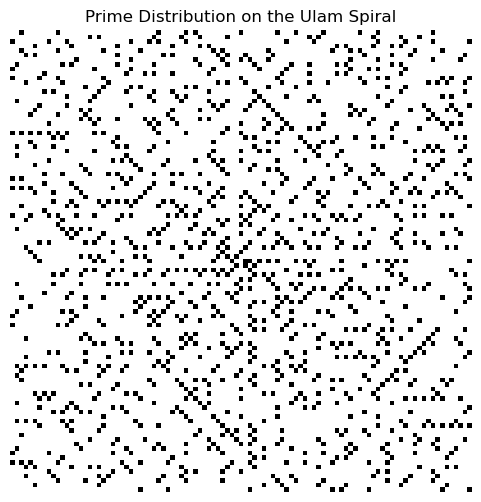

In [3]:
plt.figure(figsize=(6, 6))
plt.imshow(prime_mask, cmap="Greys")
plt.title("Prime Distribution on the Ulam Spiral")
plt.axis("off")


(np.float64(-0.5), np.float64(100.5), np.float64(100.5), np.float64(-0.5))

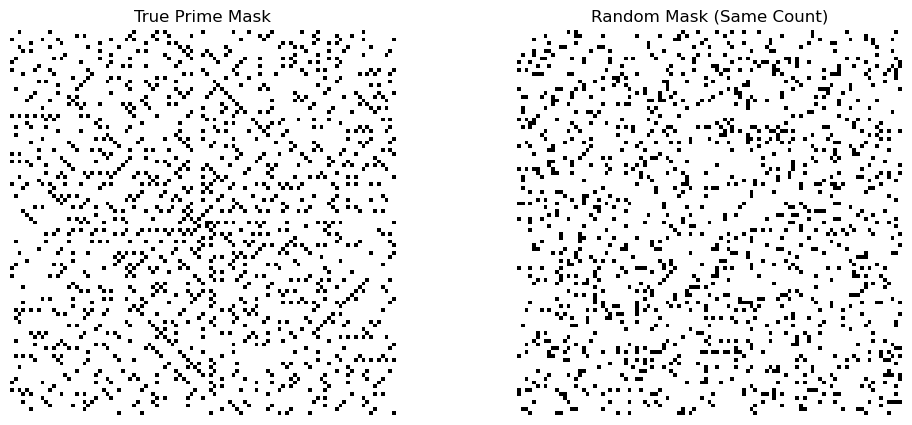

In [4]:
num_primes = np.sum(prime_mask)

random_mask = np.zeros_like(prime_mask).flatten()
random_mask[:num_primes] = 1
np.random.shuffle(random_mask)
random_mask = random_mask.reshape(prime_mask.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(prime_mask, cmap="Greys")
plt.title("True Prime Mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(random_mask, cmap="Greys")
plt.title("Random Mask (Same Count)")
plt.axis("off")


(np.float64(-0.5), np.float64(100.5), np.float64(100.5), np.float64(-0.5))

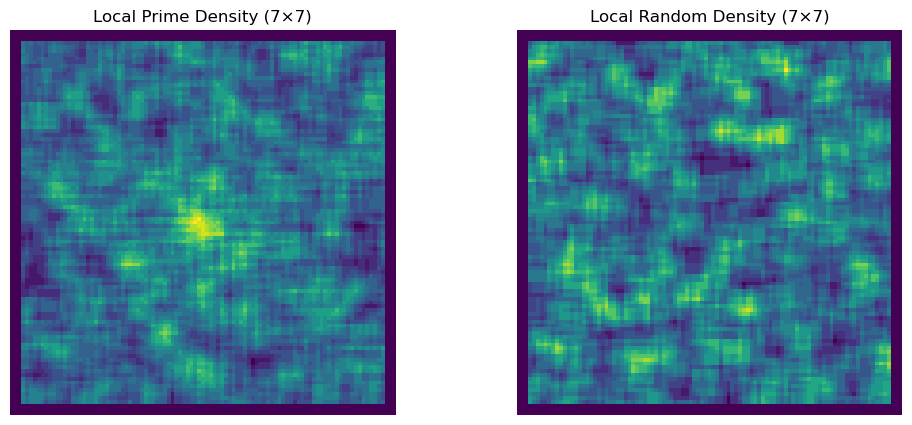

In [5]:
def local_density(mask, window_size=7):
    w = window_size // 2
    density_map = np.zeros_like(mask, dtype=float)

    for i in range(w, mask.shape[0] - w):
        for j in range(w, mask.shape[1] - w):
            window = mask[i-w:i+w+1, j-w:j+w+1]
            density_map[i, j] = np.mean(window)
    
    return density_map


prime_density = local_density(prime_mask, window_size=7)
random_density = local_density(random_mask, window_size=7)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(prime_density, cmap="viridis")
plt.title("Local Prime Density (7×7)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(random_density, cmap="viridis")
plt.title("Local Random Density (7×7)")
plt.axis("off")


### Reflection

1. What visible differences exist between the real density map and the random density map?

2. Which features look like they might be learnable, even if they are not causal?

3. Does the diagonal structure imply local predictability, or only global organisation?

4. Current hypothesis about local predictability of primes:


In [9]:
from src.windows.extract import extract_windows

WINDOW_SIZE = 7

X, y = extract_windows(prime_mask, WINDOW_SIZE)

# Remove centre information to prevent leakage
center = WINDOW_SIZE // 2
X[:, center, center] = 0

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Number of prime-centered windows:", np.sum(y))


X shape: (9025, 7, 7)
y shape: (9025,)
Number of prime-centered windows: 1121


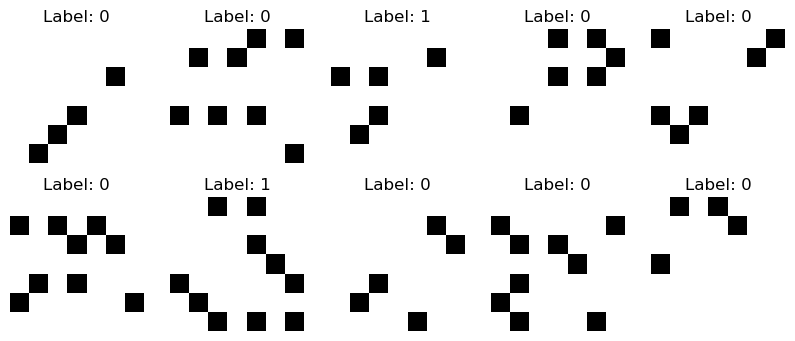

In [11]:
import matplotlib.pyplot as plt

# Show 10 random windows
indices = np.random.choice(len(X), 10, replace=False)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx], cmap="Greys")
    plt.title(f"Label: {y[idx]}")
    plt.axis("off")


In [12]:
# logistic regression on flattened windows
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Flatten windows for a simple baseline model
X_flat = X.reshape(len(X), -1)

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.25, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1977
           1       0.43      0.09      0.14       280

    accuracy                           0.87      2257
   macro avg       0.66      0.53      0.54      2257
weighted avg       0.83      0.87      0.83      2257

Confusion matrix:
 [[1945   32]
 [ 256   24]]
